In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, LearningCurveDisplay
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

## Constants


In [2]:
FBETA_BETA = 3

## Load raw data

In [4]:
df = pd.read_csv("data/original.csv", sep=";")
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## Sanitize data

In [5]:
mapping = {}
for c in df.columns:
    # print(c)
    c2 = c.lower()
    c2 = c2.replace(" ", "_")
    c2 = c2.replace("'s", "")
    c2 = c2.replace("/", "_")
    c2 = c2.replace("(", "").replace(")", "")
    c2 = c2.replace("curricular_units_", "")
    c2 = c2.strip()
    mapping[c] = c2
df = df.rename(columns=mapping)

In [6]:
# Drop rows where target column has 'Enrolled' value
# this transforms the problem to binary classification of ('Dropout'=1, 'Graduate'=0)
df = df[df["target"] != "Enrolled"]

In [7]:
def transform_target(t):
    if t == "Dropout":
        return 1
    elif t == "Graduate":
        return 0
    else:
        raise Exception("unexpected target value " + t)

targets = [transform_target(v) for v in df["target"].values]
df["target"] = targets

In [8]:
df.to_csv("data.csv", index=False)
df

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,2nd_sem_credited,2nd_sem_enrolled,2nd_sem_evaluations,2nd_sem_approved,2nd_sem_grade,2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,0


## Data exploration

In [9]:
print("Has missing values?", df.isna().any().any())
print("Len", len(df))
print("Len without duplicates", len(df))
print("Num of features", len(df.columns)-1)

Has missing values? False
Len 3630
Len without duplicates 3630
Num of features 36


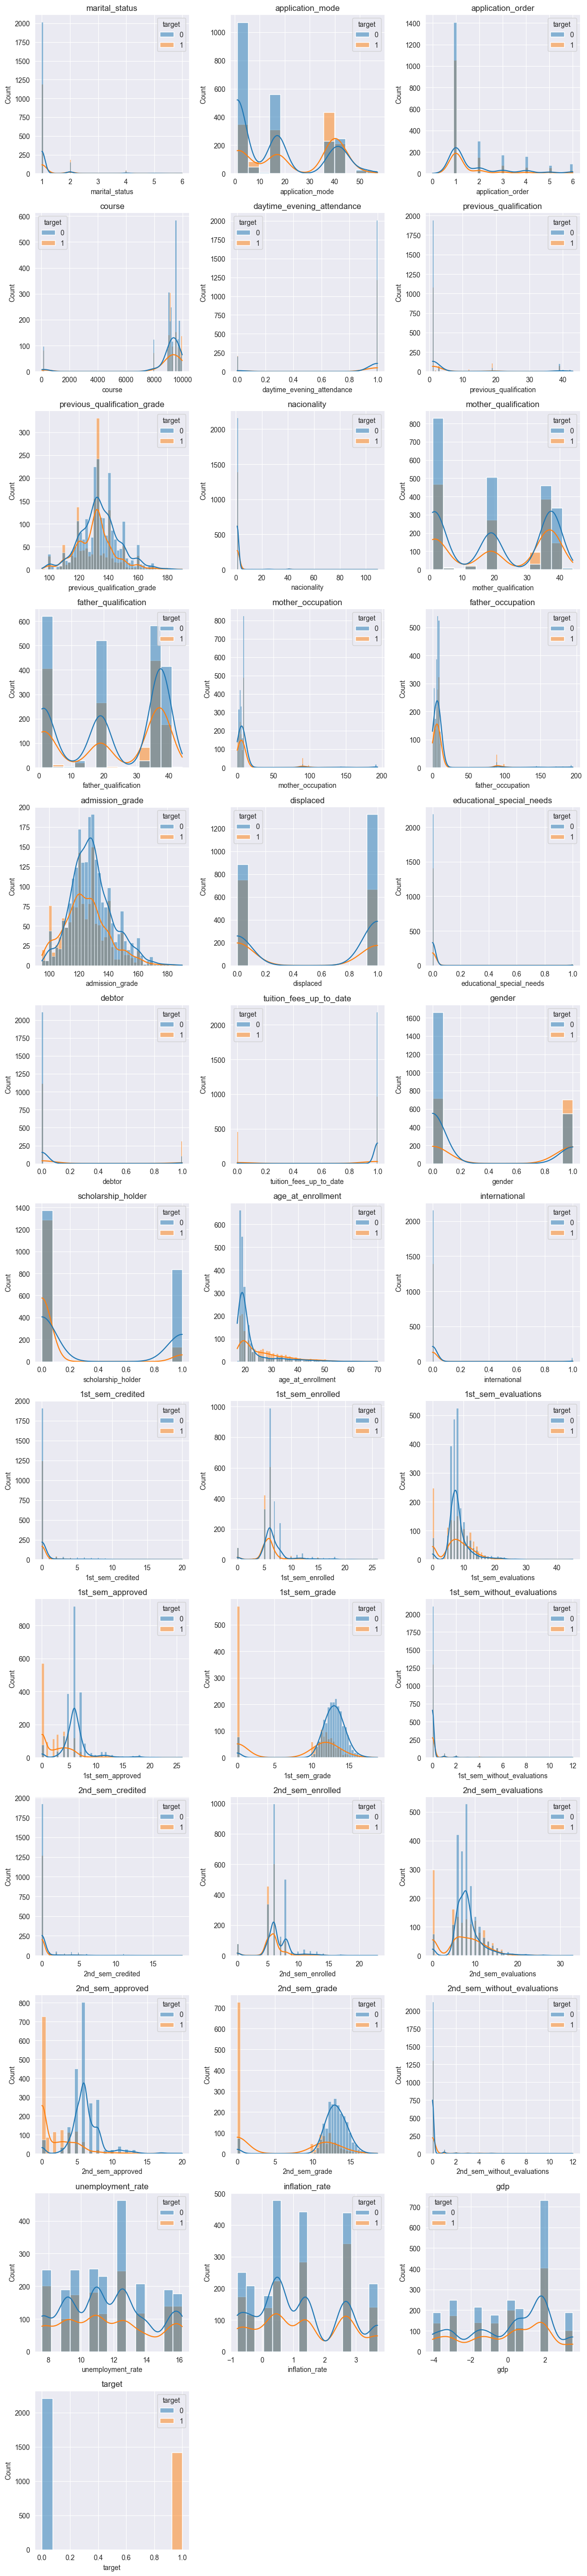

In [10]:
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sb.histplot(data=df, x=col, hue="target", kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: >

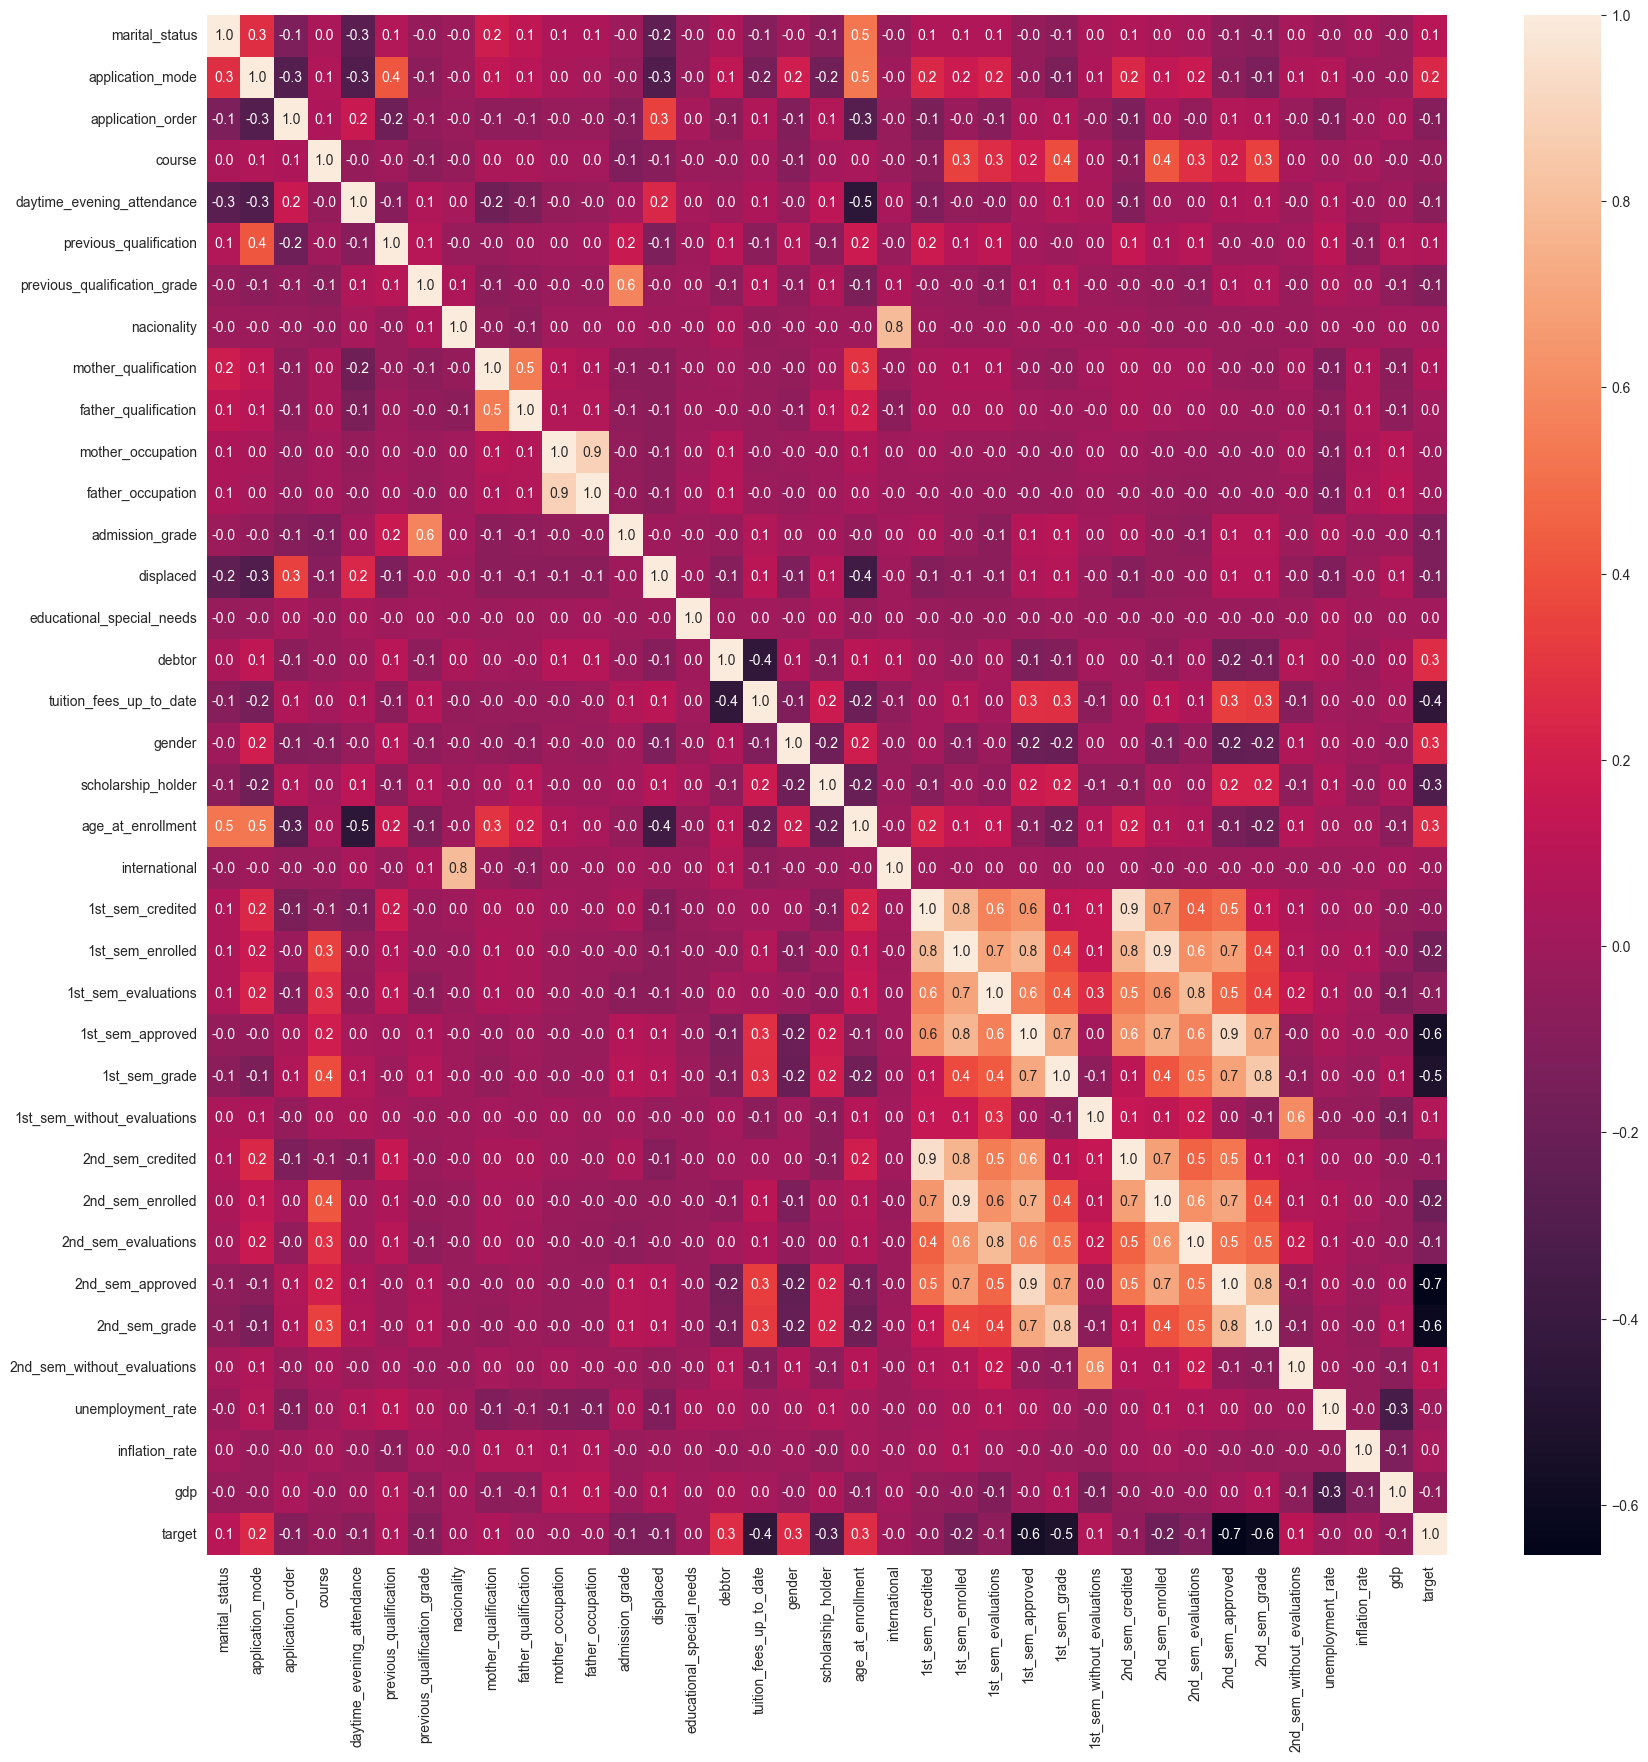

In [11]:
plt.figure(figsize=(20,20))
sb.heatmap(df.corr(), annot=True, fmt=".1f")

In [12]:
from scipy.stats import pearsonr

data = []
for col in df.columns:
    if col != "target":
        corr = pearsonr(df[col], df["target"]).statistic.round(2)
    data.append((col, corr))

corr_df = pd.DataFrame(data, columns=["col", "corr"])
corr_df["corr_abs"] = abs(corr_df["corr"])
corr_df = corr_df.sort_values(by="corr_abs", ascending=False).reset_index(drop=True)
corr_df

,col,corr,corr_abs
0,2nd_sem_approved,-0.65,0.65
1,2nd_sem_grade,-0.61,0.61
2,1st_sem_approved,-0.55,0.55
3,1st_sem_grade,-0.52,0.52
4,tuition_fees_up_to_date,-0.44,0.44
5,scholarship_holder,-0.31,0.31
6,debtor,0.27,0.27
7,age_at_enrollment,0.27,0.27
8,gender,0.25,0.25
9,application_mode,0.24,0.24


<Axes: xlabel='corr', ylabel='col'>

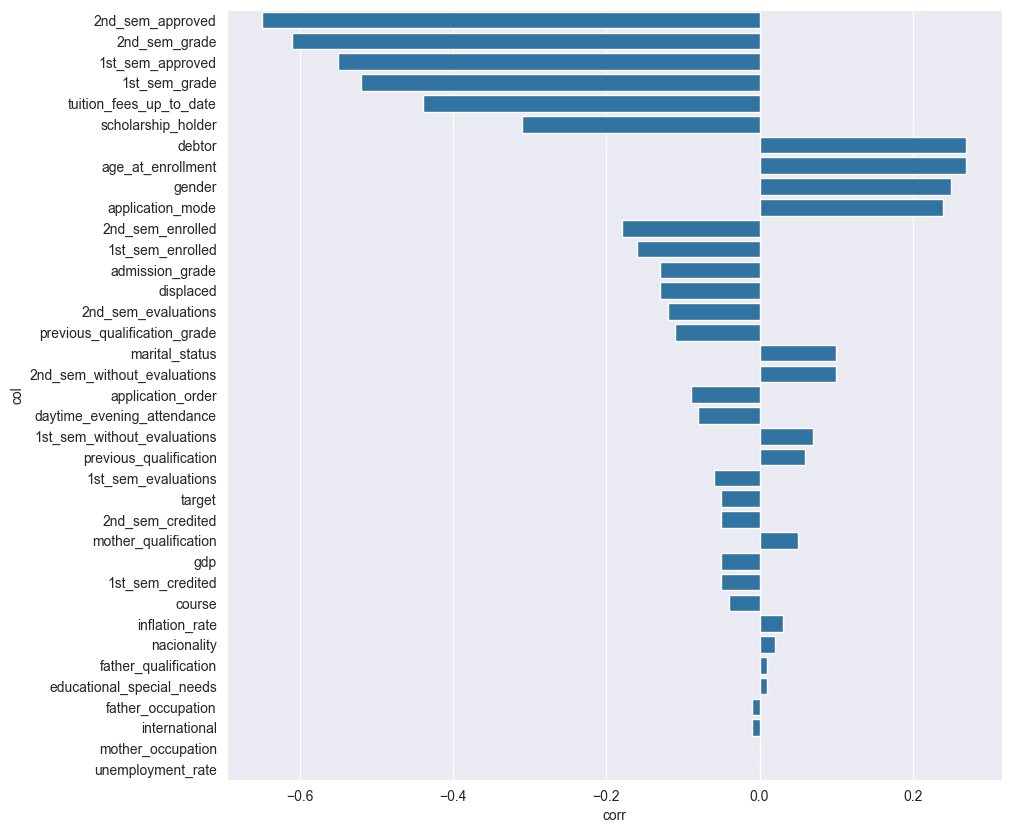

In [13]:
plt.figure(figsize=(10,10))
sb.barplot(data=corr_df, x="corr", y="col")

## Train test split

In [14]:
def xy_column_spit(df):
    x = df.drop("target", axis=1)
    y = df["target"]
    assert len(x) == len(df)
    assert len(y) == len(df)
    return x,y

TRAIN_SIZE = 0.85
TEST_SIZE = 0.15
assert(TRAIN_SIZE + TEST_SIZE == 1)

train, test = train_test_split(
    df,
    train_size=TRAIN_SIZE,
    test_size=TEST_SIZE,
    random_state=0,
    shuffle=True
)

train_x, train_y = xy_column_spit(train)
test_x, test_y = xy_column_spit(test)
print(len(train_x), len(test_x))

3085 545


In [15]:
print(train_x.columns)

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nacionality', 'mother_qualification',
       'father_qualification', 'mother_occupation', 'father_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international', '1st_sem_credited',
       '1st_sem_enrolled', '1st_sem_evaluations', '1st_sem_approved',
       '1st_sem_grade', '1st_sem_without_evaluations', '2nd_sem_credited',
       '2nd_sem_enrolled', '2nd_sem_evaluations', '2nd_sem_approved',
       '2nd_sem_grade', '2nd_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp'],
      dtype='object')



## Dimensionality reduction exploration

[0.1808589  0.1035364  0.0592521  0.05337152 0.05300366 0.04760304
 0.04400703 0.04194623 0.03609765 0.03310955 0.03071202 0.02773249
 0.02716694 0.02554711 0.02378337 0.02254216 0.02158883 0.01999661
 0.01748069 0.0158761  0.01537561 0.01453616 0.01270213 0.01232167
 0.01119291 0.00973303 0.00847746 0.00634574 0.0054583  0.00503883
 0.00426738 0.00304706 0.00260875 0.0022988  0.00084644 0.00053733]


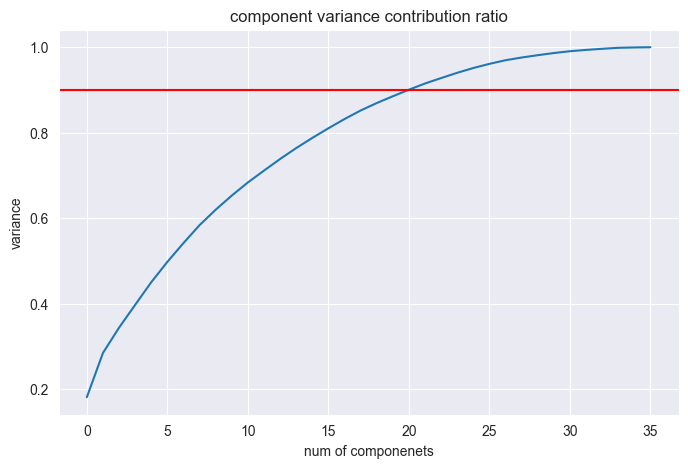

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_x_scaled = StandardScaler().fit(train_x).transform(train_x)
pca = PCA().fit(train_x_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained)
plt.xlabel('num of componenets')
plt.ylabel('variance')
plt.title('component variance contribution ratio')
plt.axhline(y=0.90, color='r')
plt.show()

> Based on this we see that 90% of the variance in the data is explained with 19 components so we will use that number.

## Baseline model

In [17]:
baseline = DummyClassifier(strategy="uniform", random_state=42)
baseline = baseline.fit(train_x, train_y)
preds = baseline.predict(test_x)
print("baseline")
print(classification_report(test_y, preds, zero_division=0))
print("fbeta", round(fbeta_score(test_y, preds, beta=FBETA_BETA),2))

baseline
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       314
           1       0.42      0.51      0.46       231

    accuracy                           0.49       545
   macro avg       0.50      0.50      0.49       545
weighted avg       0.51      0.49      0.50       545

fbeta 0.5


## Training

In [18]:
def fbeta_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return fbeta_score(y, preds, beta=2)

def train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    scorer_fn,
    tune_threshold=False,
    cv=5,
    n_jobs=5,
    show_param_grid=False
):
    import time
    start = time.time()

    # DEBUG
    if show_param_grid:
        print("Param grid")
        for k,v in param_grid.items():
            print(k,v)
        print("====")

    # GRID SEARCH AND FIT
    gs = GridSearchCV(
        estimator=create_pipeline(),
        param_grid=param_grid,
        scoring=scorer_fn,
        cv=cv,
        refit=True,
        verbose=1,
        n_jobs=n_jobs
    ).fit(train_x,train_y)

    print("Best params")
    for p in gs.best_params_:
        print(p, gs.best_params_[p])
    print("====")
    print("Best validation score:", gs.best_score_)
    print("Number of examples", len(train_x))
    print("Features", gs.best_estimator_[0].get_feature_names_out())

    # PLOT LEARNING CURVE
    common_params = {
        "X": train_x,
        "y": train_y,
        "train_sizes": np.linspace(0.05, 1.0, 5),
        "cv": cv,
        "score_type": "both",
        "n_jobs": n_jobs,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "scoring": scorer_fn,
    }
    pipeline = create_pipeline()
    pipeline.set_params(**gs.best_params_)
    LearningCurveDisplay.from_estimator(pipeline, **common_params)
    plt.show()
    T = None

    # THRESHOLD TUNING
    if tune_threshold:
        print("tuning threshold..")
        pipeline = create_pipeline()
        pipeline.set_params(**gs.best_params_)
        preds = cross_val_predict(
            pipeline,
            train_x,
            train_y,
            cv=cv,
            method="predict_proba",
            n_jobs=n_jobs
        )

        pr = []
        for T in np.arange(0, 1, 0.02):
            p = (preds[:,1]>T).astype("int")
            precision = precision_score(train_y, p)
            recall = recall_score(train_y, p)
            f1 = f1_score(train_y, p)
            fbeta = fbeta_score(train_y, p, beta=2)
            pr.append((T, recall, precision, f1, fbeta))
        pr = pd.DataFrame(data=pr, columns=["threshold", "recall", "precision", "f1", "fbeta"])
        pr = pr.sort_values(by="recall")
        plt.plot(pr["recall"], pr["precision"])
        plt.show()
        pr = pr.sort_values(by=["fbeta", "recall"], ascending=False)
        print(pr[:10].round(3))

        T = pr.head(1)["threshold"].values[0]
        print(T)

        pipeline = create_pipeline()
        pipeline.set_params(**gs.best_params_)
        preds = cross_val_predict(
            pipeline,
            train_x,
            train_y,
            cv=cv,
            method="predict_proba",
            n_jobs=n_jobs
        )
        preds = (preds[:,1]>T).astype("int")
        print(classification_report(train_y, preds))
        print("fbeta", fbeta_score(train_y, preds, beta=2))

    end = time.time()
    dur = end - start
    print("duration", round(dur, 3))

    pipeline = create_pipeline()
    pipeline.set_params(**gs.best_params_)
    return pipeline, T

In [19]:
models = {}

## Logistic classifier

### Model definition

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def extract_params(prefix: str, params: dict) -> dict:
    selected_params = {}
    prefix = prefix + "__"
    for (k, v) in params.items():
        if k.startswith(prefix):
            k = k.replace(prefix, "")
            selected_params[k] = v
    return selected_params

def logistic_sgd(pca=False):
    param_grid = {
        "clf__loss": ["log_loss"],
        "clf__random_state": [42],
        "clf__penalty": [None, "l1", "l2"],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__max_iter": np.power(10, np.arange(3, 5)),
        "clf__class_weight": [
            {0:0.5, 1:1},
            {0:1, 1:2},
        ],
    }

    if pca:
        param_grid["pca__n_components"] = [19] # list(range(15, 30, 2))

    def create_pipeline(params={}):
        steps = []
        steps.append(("scaler", StandardScaler()))
        if pca: steps.append(("pca", PCA()))#**extract_params("pca", params))))
        steps.append(("clf", SGDClassifier()))#loss="log_loss", **extract_params("clf", params))))
        return  Pipeline(steps=steps)

    return (create_pipeline, param_grid, True)

### All features

Param grid
clf__loss ['log_loss']
clf__random_state [42]
clf__penalty [None, 'l1', 'l2']
clf__alpha [0.0001, 0.001, 0.01]
clf__max_iter [ 1000 10000]
clf__class_weight [{0: 0.5, 1: 1}, {0: 1, 1: 2}]
====
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params
clf__alpha 0.001
clf__class_weight {0: 0.5, 1: 1}
clf__loss log_loss
clf__max_iter 1000
clf__penalty l2
clf__random_state 42
====
Best validation score: 0.8821165220037074
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st

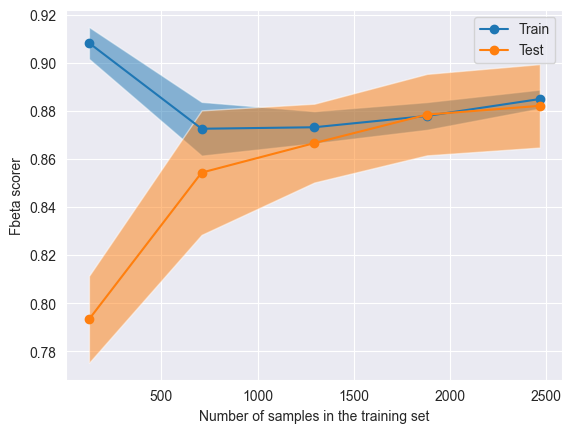

tuning threshold..


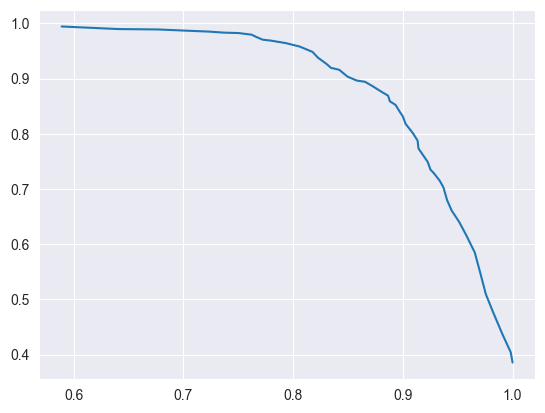

    threshold  recall  precision     f1  fbeta
22       0.44   0.900      0.832  0.864  0.885
19       0.38   0.909      0.801  0.852  0.885
18       0.36   0.913      0.788  0.846  0.885
23       0.46   0.897      0.839  0.867  0.885
24       0.48   0.893      0.852  0.872  0.885
20       0.40   0.905      0.812  0.856  0.885
21       0.42   0.903      0.818  0.858  0.884
26       0.52   0.887      0.869  0.878  0.883
25       0.50   0.888      0.859  0.873  0.882
17       0.34   0.914      0.773  0.838  0.882
0.44
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1895
           1       0.83      0.90      0.86      1190

    accuracy                           0.89      3085
   macro avg       0.88      0.89      0.89      3085
weighted avg       0.89      0.89      0.89      3085

fbeta 0.8854166666666666
duration 17.935


In [24]:
pipeline, param_grid, tune_threshold = logistic_sgd()
model, T = train(
    train_x,
    train_y,
    pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["logistic"] = {"model": model, "T": T}

### PCA (19 components)

Param grid
clf__loss ['log_loss']
clf__random_state [42]
clf__penalty [None, 'l1', 'l2']
clf__alpha [0.0001, 0.001, 0.01]
clf__max_iter [ 1000 10000]
clf__class_weight [{0: 0.5, 1: 1}, {0: 1, 1: 2}]
pca__n_components [19]
====
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params
clf__alpha 0.001
clf__class_weight {0: 0.5, 1: 1}
clf__loss log_loss
clf__max_iter 1000
clf__penalty None
clf__random_state 42
pca__n_components 19
====
Best validation score: 0.8605108222843747
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluat

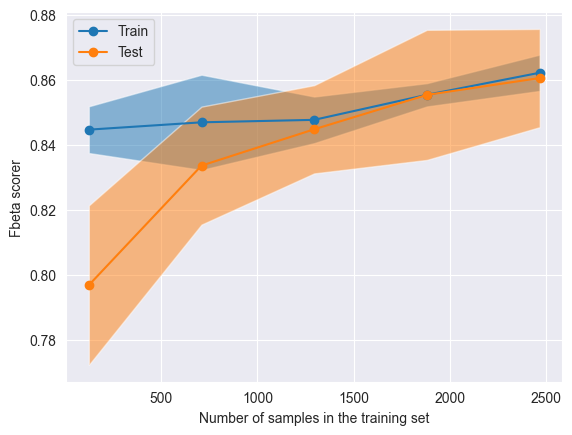

tuning threshold..


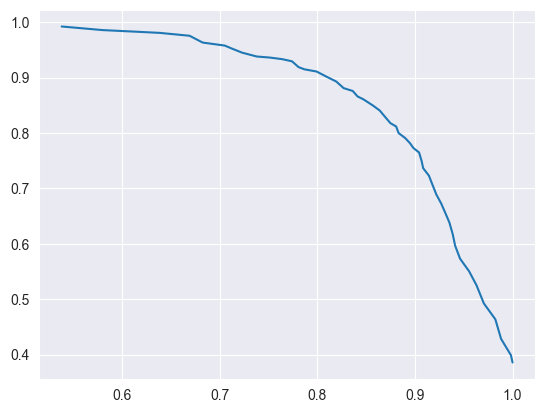

    threshold  recall  precision     f1  fbeta
18       0.36   0.904      0.765  0.829  0.872
17       0.34   0.907      0.750  0.821  0.870
19       0.38   0.898      0.773  0.831  0.870
20       0.40   0.895      0.781  0.834  0.870
15       0.30   0.914      0.723  0.807  0.868
21       0.42   0.890      0.791  0.837  0.868
16       0.32   0.908      0.736  0.813  0.868
14       0.28   0.918      0.708  0.799  0.866
23       0.46   0.881      0.812  0.845  0.866
22       0.44   0.883      0.800  0.839  0.865
0.36
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1895
           1       0.76      0.90      0.83      1190

    accuracy                           0.86      3085
   macro avg       0.85      0.86      0.85      3085
weighted avg       0.87      0.86      0.86      3085

fbeta 0.8723852764715421
duration 12.618


In [25]:
create_pipeline, param_grid, tune_threshold = logistic_sgd(pca = True)
model, T = train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["logistic_pca"] = {"model": model, "T": T}

## KNN

### Model definition

In [26]:
from sklearn.neighbors import KNeighborsClassifier

def knn(pca=False):
    grid_params = {
        "clf__n_neighbors": [100],
        "clf__weights": ["uniform", "distance"]
    }
    def create_pipeline():
        steps = []
        steps.append(("scaler", StandardScaler()))
        if pca: steps.append(("pca", PCA(19)))
        steps.append(("clf", KNeighborsClassifier()))#**extract_params("clf", params))))
        pipe = Pipeline(steps=steps)
        return pipe

    return (create_pipeline, grid_params, True)


### All features

Param grid
clf__n_neighbors [100]
clf__weights ['uniform', 'distance']
====
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params
clf__n_neighbors 100
clf__weights distance
====
Best validation score: 0.6286465606097069
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st_sem_without_evaluations' '2nd_sem_credited' '2nd_sem_enrolled'
 '2nd_sem_evaluations' '2nd_sem_approved' '2nd_sem_grade'
 '2nd_sem_without_evaluations' 'unemployment_rate' 'inflation_rate' 'gdp']


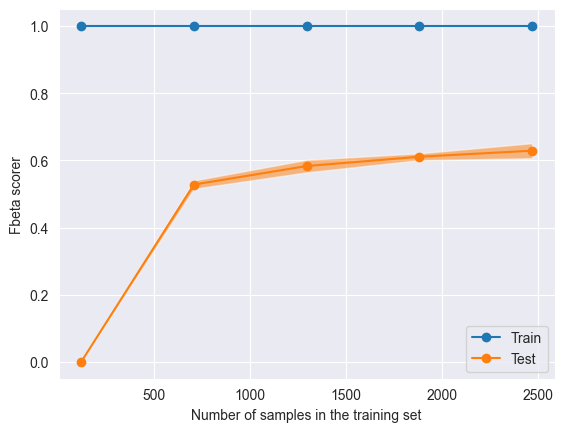

tuning threshold..


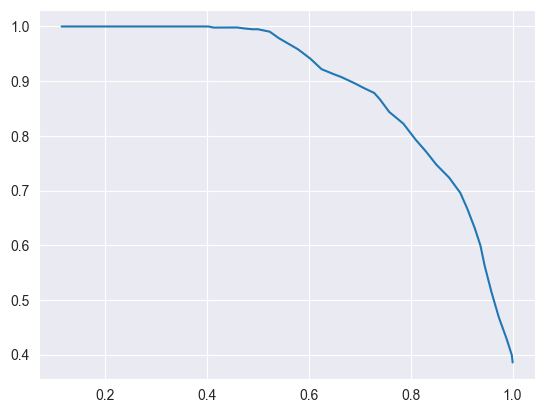

    threshold  recall  precision     f1  fbeta
9        0.18   0.911      0.667  0.770  0.849
10       0.20   0.897      0.696  0.784  0.848
8        0.16   0.926      0.631  0.750  0.847
7        0.14   0.937      0.599  0.731  0.842
11       0.22   0.876      0.724  0.792  0.840
6        0.12   0.945      0.562  0.705  0.832
12       0.24   0.850      0.747  0.796  0.828
13       0.26   0.830      0.771  0.800  0.818
5        0.10   0.959      0.514  0.669  0.817
14       0.28   0.810      0.793  0.801  0.807
0.18
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1895
           1       0.67      0.91      0.77      1190

    accuracy                           0.79      3085
   macro avg       0.80      0.81      0.79      3085
weighted avg       0.83      0.79      0.79      3085

fbeta 0.8489974937343359
duration 6.154


In [27]:
create_pipeline, param_grid, tune_threshold = knn()
model, T = train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)
models["knn"] = {"model": model, "T": T}

In [28]:
model.steps[1][1].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 100,
 'p': 2,
 'weights': 'distance'}

### PCA (19 components)

Param grid
clf__n_neighbors [100]
clf__weights ['uniform', 'distance']
====
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params
clf__n_neighbors 100
clf__weights distance
====
Best validation score: 0.6613976881711418
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st_sem_without_evaluations' '2nd_sem_credited' '2nd_sem_enrolled'
 '2nd_sem_evaluations' '2nd_sem_approved' '2nd_sem_grade'
 '2nd_sem_without_evaluations' 'unemployment_rate' 'inflation_rate' 'gdp']


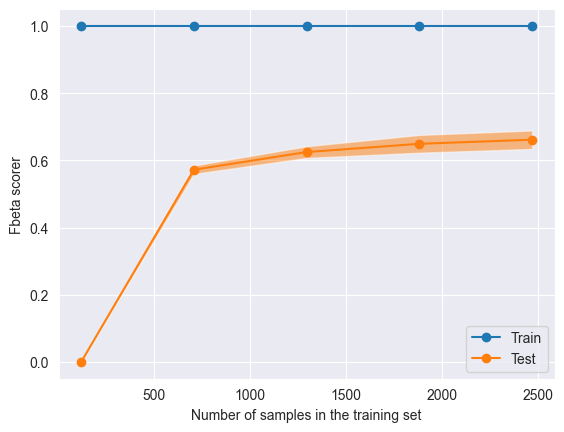

tuning threshold..


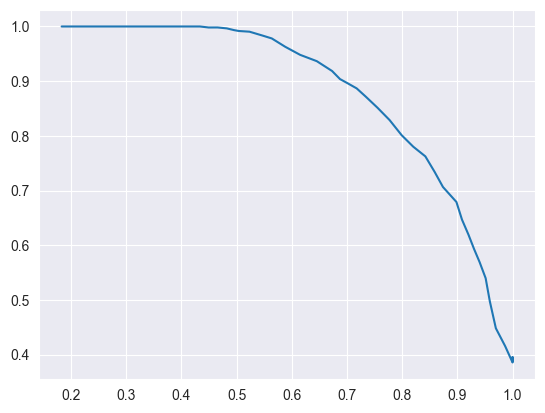

    threshold  recall  precision     f1  fbeta
11       0.22   0.898      0.679  0.774  0.844
10       0.20   0.908      0.647  0.756  0.840
9        0.18   0.920      0.619  0.740  0.839
8        0.16   0.930      0.593  0.724  0.835
12       0.24   0.874      0.707  0.781  0.834
7        0.14   0.940      0.569  0.709  0.832
13       0.26   0.859      0.734  0.792  0.831
6        0.12   0.951      0.540  0.689  0.825
14       0.28   0.842      0.763  0.800  0.825
15       0.30   0.820      0.780  0.800  0.812
0.22
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1895
           1       0.68      0.90      0.77      1190

    accuracy                           0.80      3085
   macro avg       0.80      0.82      0.79      3085
weighted avg       0.83      0.80      0.80      3085

fbeta 0.8438585412061889
duration 5.786


In [29]:
create_pipeline, param_grid, tune_threshold = knn(True)
model, T = train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["knn_pca"] = {"model": model, "T": T}

## SVM

### Model definition

In [30]:
from sklearn.svm import SVC

def svm(pca=False):
    grid_params = {
        "clf__C": [1.5],
        "clf__kernel": ["poly", "rbf"],
        "clf__degree": [3,5],
        "clf__class_weight": [{0:1, 1:i} for i in range(3,6,1)],
        "clf__probability": [True]
    }

    def create_pipeline():
        steps = []
        steps.append(("scaler", StandardScaler()))
        if pca: steps.append(("pca", PCA(19)))
        steps.append(("clf", SVC()))
        pipe = Pipeline(steps)
        return pipe

    return (create_pipeline, grid_params)

### All features

Param grid
clf__C [1.5]
clf__kernel ['poly', 'rbf']
clf__degree [3, 5]
clf__class_weight [{0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
clf__probability [True]
====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params
clf__C 1.5
clf__class_weight {0: 1, 1: 5}
clf__degree 3
clf__kernel rbf
clf__probability True
====
Best validation score: 0.8708444489875136
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st_sem_without_evaluations' '2nd_sem_credited' '2nd_sem_enrolled'
 '2nd_sem_e

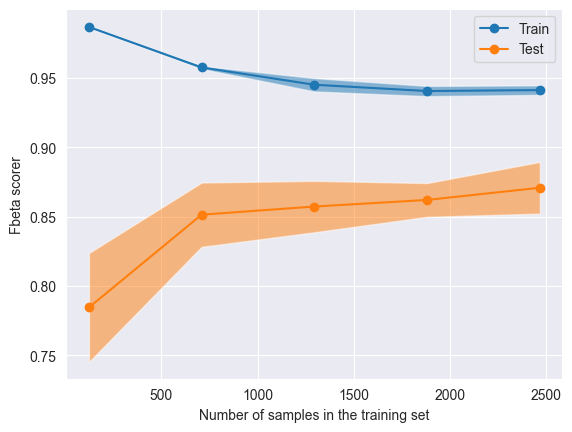

tuning threshold..


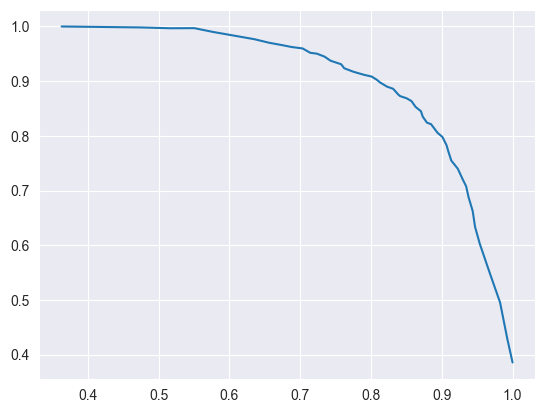

    threshold  recall  precision     f1  fbeta
10       0.20   0.923      0.740  0.821  0.879
13       0.26   0.907      0.783  0.840  0.879
9        0.18   0.929      0.721  0.812  0.879
14       0.28   0.901      0.798  0.846  0.878
8        0.16   0.934      0.708  0.806  0.878
12       0.24   0.909      0.772  0.835  0.878
11       0.22   0.913      0.755  0.827  0.877
15       0.30   0.894      0.805  0.847  0.875
7        0.14   0.938      0.688  0.794  0.874
16       0.32   0.885      0.821  0.852  0.871
0.2
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1895
           1       0.74      0.92      0.82      1190

    accuracy                           0.85      3085
   macro avg       0.84      0.86      0.84      3085
weighted avg       0.86      0.85      0.85      3085

fbeta 0.8793849111004325
duration 77.89


In [31]:
create_pipeline, param_grid = svm()
model, T = train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["svm"] = {"model": model, "T": T}

### PCA (19 components)

Param grid
clf__C [1.5]
clf__kernel ['poly', 'rbf']
clf__degree [3, 5]
clf__class_weight [{0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
clf__probability [True]
====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params
clf__C 1.5
clf__class_weight {0: 1, 1: 3}
clf__degree 3
clf__kernel rbf
clf__probability True
====
Best validation score: 0.8629997975926326
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st_sem_without_evaluations' '2nd_sem_credited' '2nd_sem_enrolled'
 '2nd_sem_e

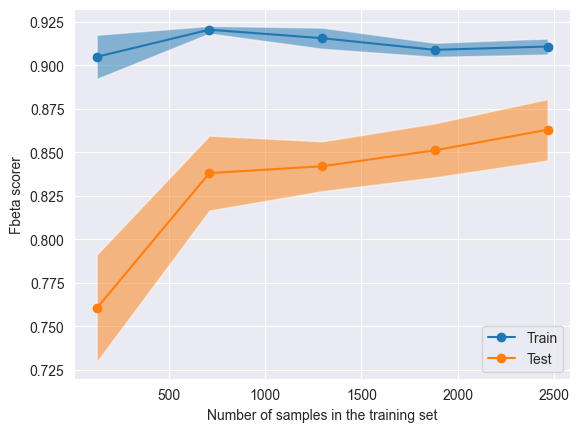

tuning threshold..


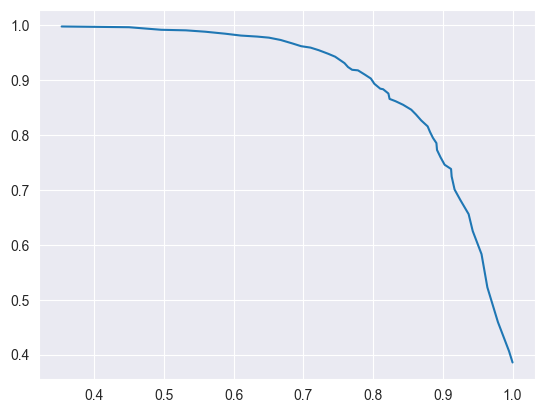

    threshold  recall  precision     f1  fbeta
10       0.20   0.912      0.738  0.816  0.871
9        0.18   0.913      0.724  0.808  0.868
14       0.28   0.891      0.785  0.835  0.867
11       0.22   0.903      0.746  0.817  0.866
15       0.30   0.886      0.795  0.838  0.866
12       0.24   0.897      0.759  0.822  0.865
16       0.32   0.882      0.806  0.842  0.865
13       0.26   0.892      0.773  0.828  0.865
17       0.34   0.878      0.816  0.846  0.865
8        0.16   0.917      0.701  0.794  0.864
0.2
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1895
           1       0.74      0.91      0.82      1190

    accuracy                           0.84      3085
   macro avg       0.84      0.85      0.84      3085
weighted avg       0.86      0.84      0.84      3085

fbeta 0.8702633269107257
duration 66.301


In [32]:
create_pipeline, param_grid = svm(pca=True)
model, T = train(
    train_x,
    train_y,
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)
models["svm_pca"] = {"model": model, "T": T}

## Eval

In [33]:
def eval(model_info):
    model = model_info["model"]
    model = model.fit(train_x, train_y)
    if "T" in model_info:
        T = model_info["T"]
        preds = model.predict_proba(test_x)
        preds = (preds[:,1]>T).astype("int")
    else:
        preds = model.predict(test_x)
    # print(classification_report(test_y, preds))
    fbeta = fbeta_score(test_y, preds, beta=2)
    print("fbeta", fbeta)

for model in models:
    print(model)
    eval(models[model])

logistic
fbeta 0.8868894601542416
logistic_pca
fbeta 0.8699324324324325
knn
fbeta 0.8525535420098846
knn_pca
fbeta 0.8505367464905037
svm
fbeta 0.8838383838383839
svm_pca
fbeta 0.8578637510513036
